In [1]:
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import geopandas as gpd
import pandas as pd
from distmetrics import compute_mahalonobis_dist_2d, compute_transformer_zscore, load_trained_transformer_model

import matplotlib.pyplot as plt
import warnings
import numpy as np
import concurrent.futures
import rasterio
from pyproj import Transformer
from rasterio.crs import CRS
from tqdm import tqdm
from pathlib import Path
from val_io import get_burst_time_series_around_point, get_utm_coords
from distmetrics import despeckle_rtc_arrs_with_tv
import json

# Parameters

In [4]:
SITE_ID = 158 # 40 #95
IDX_BURST = 1 # should be 0 or 1. Note that some sites only have 1 burst, so only 0 IDX is valid
LOOKBACK_DELTA_DAYS = 365 

MAX_PRE_IMGS = 10
MIN_PRE_IMGS = 4

N_CPUS = 5

WINDOW_SIZE = 101

# Site Table

In [5]:
df_sites = gpd.read_file('data/val_sites_subset.geojson')
df_sites.head()

,site_id,change_label,change_type,change_time,last_observation_time,mgrs_tile_id,jpl_burst_id,geometry
0,4,VLmaj,Fire,2021-11-07,2021-11-02,34NCL,T036-076228-IW3,POINT (19.33289 4.57490)
1,13,VLmaj,Crop cycle change,2021-10-03,NaT,39STR,T108-230715-IW2,POINT (48.77698 31.75490)
2,13,VLmaj,Crop cycle change,2021-10-03,NaT,39STR,T101-214979-IW1,POINT (48.77698 31.75490)
3,22,VLmin,Natural browning,2021-12-19,2021-12-12,37SBV,T014-028130-IW2,POINT (36.61178 35.52891)
4,22,VLmin,Natural browning,2021-12-19,2021-12-12,37SBV,T021-043823-IW2,POINT (36.61178 35.52891)


In [6]:
df_site = df_sites[df_sites.site_id == SITE_ID].reset_index(drop=True)
df_site

,site_id,change_label,change_type,change_time,last_observation_time,mgrs_tile_id,jpl_burst_id,geometry
0,158,VLmaj,Crop cycle change,2021-11-13,2021-11-03,37TCN,T167-357347-IW1,POINT (37.02294 47.62284)
1,158,VLmaj,Crop cycle change,2021-11-13,2021-11-03,37TCN,T116-247291-IW3,POINT (37.02294 47.62284)
2,158,VLmaj,Crop cycle change,2021-11-13,2021-11-03,37TCN,T167-357346-IW1,POINT (37.02294 47.62284)


# Bursts

In [7]:
df_val_bursts = gpd.read_parquet('data/validation_bursts_v1_coverage_updated.parquet')
df_val_bursts.head()

,jpl_burst_id,geometry,n_acquisitions,site_id
0,T005-008692-IW2,"POLYGON ((-97.21446 17.86505, -97.21446 17.864...",104,72
1,T008-015865-IW2,"POLYGON ((-1.50129 41.44183, -1.50130 41.44156...",101,150
2,T012-024584-IW1,"POLYGON ((-103.78409 20.20832, -103.78409 20.2...",101,34
3,T014-028130-IW2,"POLYGON ((37.01648 35.59545, 37.01649 35.59518...",100,22
4,T014-028131-IW2,"POLYGON ((36.98085 35.76145, 36.98085 35.76118...",38,22


In [8]:
df_bursts_for_site = df_val_bursts[df_val_bursts.site_id == SITE_ID].reset_index(drop=True)
df_bursts_for_site.head()

,jpl_burst_id,geometry,n_acquisitions,site_id
0,T116-247291-IW3,"POLYGON ((37.37307 47.74900, 37.37304 47.74873...",102,158
1,T167-357346-IW1,"POLYGON ((36.18999 47.90358, 36.18995 47.90277...",102,158
2,T167-357347-IW1,"POLYGON ((36.14347 47.73856, 36.14334 47.73641...",102,158


# RTC Data

In [9]:
BURST_ID = df_bursts_for_site.iloc[IDX_BURST].jpl_burst_id

In [10]:
df_rtc = pd.read_json('data/rtc_s1_table.json.zip')
df_rtc_ts = df_rtc[df_rtc.jpl_burst_id == BURST_ID].reset_index(drop=True)
df_rtc_ts['acq_datetime'] = pd.to_datetime(df_rtc_ts['acq_datetime'])
df_rtc_ts.head()

,rtc_s1_id,input_slc_id,jpl_burst_id,bursts_per_slc_input,rtc_s1_vv_url,rtc_s1_vh_url,rtc_s1_h5_url,acq_datetime
0,OPERA_L2_RTC-S1_T167-357346-IW1_20201003T03473...,S1B_IW_SLC__1SDV_20201003T034719_20201003T0347...,T167-357346-IW1,32,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,2020-10-03 03:47:19
1,OPERA_L2_RTC-S1_T167-357346-IW1_20201009T03481...,S1A_IW_SLC__1SDV_20201009T034811_20201009T0348...,T167-357346-IW1,28,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,2020-10-09 03:48:11
2,OPERA_L2_RTC-S1_T167-357346-IW1_20201015T03473...,S1B_IW_SLC__1SDV_20201015T034719_20201015T0347...,T167-357346-IW1,32,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,2020-10-15 03:47:19
3,OPERA_L2_RTC-S1_T167-357346-IW1_20201021T03481...,S1A_IW_SLC__1SDV_20201021T034751_20201021T0348...,T167-357346-IW1,30,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,2020-10-21 03:47:51
4,OPERA_L2_RTC-S1_T167-357346-IW1_20201027T03473...,S1B_IW_SLC__1SDV_20201027T034719_20201027T0347...,T167-357346-IW1,32,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,2020-10-27 03:47:19


# Load Data

In [11]:
geo = df_site.geometry[0]
lon, lat = geo.x, geo.y
vv_url = df_rtc_ts.rtc_s1_vv_url[0]

In [12]:
with rasterio.open(vv_url) as ds:
    profile_ref = ds.profile
    utm_crs = ds.crs

In [13]:
utm_x, utm_y = get_utm_coords(utm_crs, lon, lat)
utm_x, utm_y

(802251.1509761794, 5282226.241872362)

In [14]:
%%time

vv_data = get_burst_time_series_around_point(df_rtc_ts.rtc_s1_vv_url.tolist(), lon, lat, window_size=WINDOW_SIZE, n_workers=N_CPUS)

100%|████████████████████████████████████████| 102/102 [00:28<00:00,  4.88it/s]

CPU times: user 711 ms, sys: 483 ms, total: 1.19 s
Wall time: 55.5 s


In [15]:
vv_arrs, profs = zip(*vv_data)
vv_arrs = [vv[0, ...] for vv in vv_arrs]

prof_window = profs[0]
prof_window

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 101, 'height': 101, 'count': 1, 'crs': CRS.from_epsg(32636), 'transform': Affine(30.0, 0.0, 800730.0,
       0.0, -30.0, 5283750.0), 'blockxsize': 512, 'blockysize': 512, 'tiled': True, 'compress': 'deflate', 'interleave': 'band'}

In [16]:
%%time

vh_data = get_burst_time_series_around_point(df_rtc_ts.rtc_s1_vh_url.tolist(), 
                                             lon, 
                                             lat, 
                                             n_workers=N_CPUS,
                                             window_size=WINDOW_SIZE)

100%|████████████████████████████████████████| 102/102 [00:29<00:00,  4.72it/s]

CPU times: user 811 ms, sys: 514 ms, total: 1.32 s
Wall time: 59.9 s


In [17]:
vh_arrs, _ = zip(*vh_data)
vh_arrs = [vh[0, ...] for vh in vh_arrs]

In [18]:
arrs_vv_d = despeckle_rtc_arrs_with_tv(vv_arrs, n_jobs=N_CPUS)
arrs_vh_d = despeckle_rtc_arrs_with_tv(vh_arrs, n_jobs=N_CPUS)

100%|███████████████████████████████████████| 102/102 [00:00<00:00, 545.11it/s]


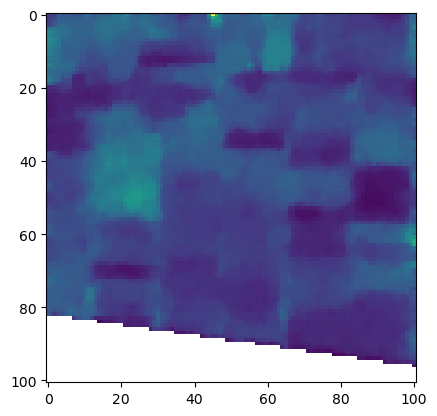

In [19]:
plt.imshow(arrs_vv_d[0])

# Generate Pre/Post Groups

The validation data starts here: https://github.com/OPERA-Cal-Val/DIST-Validation

In [20]:
VAL_START_DATE = pd.Timestamp('2021-10-01')

In [21]:
# The acquisition times should be sorted from oldest to newest
acq_datetimes_all = df_rtc_ts['acq_datetime'].tolist()
post_dts_all = [acq_dt for acq_dt in acq_datetimes_all if acq_dt >= VAL_START_DATE]
post_idx_all = [idx for idx, acq_dt in enumerate(acq_datetimes_all) if acq_dt >= VAL_START_DATE]
post_dts_all[:3], post_idx_all[:3]

([Timestamp('2021-10-04 03:47:57'),
  Timestamp('2021-10-10 03:47:24'),
  Timestamp('2021-10-16 03:47:57')],
 [61, 62, 63])

In [22]:
def get_pre_dates(post_dt: pd.Timestamp,
                  max_dates=MAX_PRE_IMGS,
                  as_idx=False) -> list:
    pre = []
    if as_idx:
        pre = [idx for idx, dt in enumerate(acq_datetimes_all) if dt < post_dt - pd.Timedelta(LOOKBACK_DELTA_DAYS, unit='D')]
    else:
        pre = [dt for dt in acq_datetimes_all if dt <= post_dt - pd.Timedelta(LOOKBACK_DELTA_DAYS, unit='D')]
    return pre[-MAX_PRE_IMGS:]

In [23]:
pre_post_dts = [{'pre': get_pre_dates(post_dt, 
                                      max_dates=MAX_PRE_IMGS,
                                      as_idx=False),
                 'post': [post_dt]} for post_dt in post_dts_all]
pre_post_dts = [data for data in pre_post_dts if len(data['pre']) >= MIN_PRE_IMGS]
pre_post_dts[0]

{'pre': [Timestamp('2020-10-03 03:47:19'),
  Timestamp('2020-10-09 03:48:11'),
  Timestamp('2020-10-15 03:47:19'),
  Timestamp('2020-10-21 03:47:51')],
 'post': [Timestamp('2021-10-22 03:47:25')]}

In [24]:
pre_post_idx = [{'pre': get_pre_dates(post_dt, 
                                      max_dates=MAX_PRE_IMGS,
                                      as_idx=True),
                 'post': [idx]} for idx, post_dt in zip(post_idx_all, post_dts_all)]
pre_post_idx = [data for data in pre_post_idx if len(data['pre']) >= MIN_PRE_IMGS]
pre_post_idx[0]

{'pre': [0, 1, 2, 3], 'post': [64]}

In [25]:
post_dates = [d['post'][0] for d in pre_post_dts]
post_dates[:3]

[Timestamp('2021-10-22 03:47:25'),
 Timestamp('2021-10-28 03:47:57'),
 Timestamp('2021-11-03 03:47:24')]

# Change index

# Serialize Imagery


In [26]:
out = Path('out')
site_burst_dir = out / f'site_{SITE_ID}' / BURST_ID
site_burst_dir.mkdir(exist_ok=True, parents=True)

In [27]:
rtc_dir = site_burst_dir / 'rtc_ts'
rtc_dir.mkdir(exist_ok=True, parents=True)

In [28]:
from itertools import starmap

def serialize_one_rtc(rtc_arr: np.ndarray, fn: Path, out_dir = rtc_dir):
    out_path = rtc_dir / fn
    with rasterio.open(out_path, 'w', **prof_window) as ds:
        ds.write(rtc_arr, 1)
    return out_path


out_paths = [url.split('/')[-1] for url in df_rtc_ts.rtc_s1_vv_url.tolist()] + [url.split('/')[-1] for url in df_rtc_ts.rtc_s1_vh_url.tolist()]
arrs = arrs_vv_d + arrs_vh_d

out_paths = [serialize_one_rtc(arr, p) for (arr, p) in zip(tqdm(arrs), out_paths)]
out_paths[:4]

100%|███████████████████████████████████████| 204/204 [00:00<00:00, 369.64it/s]


[PosixPath('out/site_158/T167-357346-IW1/rtc_ts/OPERA_L2_RTC-S1_T167-357346-IW1_20201003T034731Z_20240426T215546Z_S1B_30_v1.0_VV.tif'),
 PosixPath('out/site_158/T167-357346-IW1/rtc_ts/OPERA_L2_RTC-S1_T167-357346-IW1_20201009T034814Z_20240426T174407Z_S1A_30_v1.0_VV.tif'),
 PosixPath('out/site_158/T167-357346-IW1/rtc_ts/OPERA_L2_RTC-S1_T167-357346-IW1_20201015T034732Z_20240426T222030Z_S1B_30_v1.0_VV.tif'),
 PosixPath('out/site_158/T167-357346-IW1/rtc_ts/OPERA_L2_RTC-S1_T167-357346-IW1_20201021T034813Z_20240426T181800Z_S1A_30_v1.0_VV.tif')]

In [29]:
class PandasTimestampEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, pd.Timestamp):
            return obj.isoformat()
        return super().default(obj)

In [30]:
with open(rtc_dir / f'dates_delta{LOOKBACK_DELTA_DAYS}.json', 'w') as f:
    json.dump(pre_post_dts, f, cls=PandasTimestampEncoder, indent=2)

In [31]:
with open(rtc_dir / f'idx_delta{LOOKBACK_DELTA_DAYS}.json', 'w') as f:
    json.dump(pre_post_idx, f, indent=2)